# Generating MNIST digits using DC-GAN

In continuation to previous tutorial on generating MNIST using simple GAN, this guide is an improvement over it.
We use convolution layers in the generator and discriminator network. Hence, the name.

In [1]:
import numpy as np
from scipy.io import loadmat
import keras
import keras.backend as K
from keras.layers import Dense, Activation, LeakyReLU, BatchNormalization
from keras.layers import Conv2D, Conv2DTranspose, Reshape, Flatten
from keras.models import Sequential
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

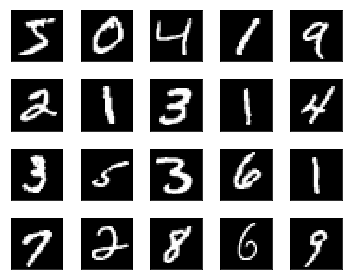

In [3]:
plt.figure(figsize=(5, 4))
for i in range(20):
    plt.subplot(4, 5, i+1)
    plt.imshow(X_train[i], cmap='gray')
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()

In [4]:
def preprocess(x):    
    x = x.reshape(-1, 28, 28, 1) # 28,28,1
    x = np.float64(x)
    x = (x / 255 - 0.5) * 2
    x = np.clip(x, -1, 1)
    return x

def deprocess(x):
    x = (x / 2 + 1) * 255
    x = np.clip(x, 0, 255)
    x = np.uint8(x)
    x = x.reshape(28, 28)
    return x

In [5]:
X_train_real = preprocess(X_train)
X_test_real  = preprocess(X_test)

In [6]:
def make_generator(input_size, leaky_alpha):
    # generates images in (28,28,1)
    return Sequential([
        # FC 1: 7,7,16
        Dense(784, input_shape=(input_size,)),
        Reshape(target_shape=(7, 7, 16)),
        BatchNormalization(),
        LeakyReLU(alpha=leaky_alpha),
        
        # Conv 1: 14,14,32
        Conv2DTranspose(32, kernel_size=5, strides=2, padding='same'), 
        BatchNormalization(),
        LeakyReLU(alpha=leaky_alpha),
        
        # Conv 2: 28,28,1
        Conv2DTranspose(1, kernel_size=5, strides=2, padding='same'),
        Activation('tanh')
    ])

In [7]:
def make_discriminator(leaky_alpha):
    # classifies images in (28,28,1)
    return Sequential([        
        # Conv 1: 14,14,32
        Conv2D(32, kernel_size=5, strides=2, padding='same', input_shape=(28,28,1)),
        LeakyReLU(alpha=leaky_alpha),
        
        # Conv 2: 7,7,16
        Conv2D(16, kernel_size=5, strides=2, padding='same'),   
        BatchNormalization(),
        LeakyReLU(alpha=leaky_alpha),
        
        # FC 1
        Flatten(),
        Dense(784),
        BatchNormalization(),
        LeakyReLU(alpha=leaky_alpha),
        
        # Output
        Dense(1),
        Activation('sigmoid')        
    ])

In [8]:
# beta_1 is the exponential decay rate for the 1st moment estimates in Adam optimizer
def make_DCGAN(sample_size, 
               g_learning_rate,
               g_beta_1,
               d_learning_rate,
               d_beta_1,
               leaky_alpha):
    # clear first
    K.clear_session()
    
    # generator
    generator = make_generator(sample_size, leaky_alpha)

    # discriminator
    discriminator = make_discriminator(leaky_alpha)
    discriminator.compile(optimizer=Adam(lr=d_learning_rate, beta_1=d_beta_1), loss='binary_crossentropy')
    
    # GAN
    gan = Sequential([generator, discriminator])
    gan.compile(optimizer=Adam(lr=g_learning_rate, beta_1=g_beta_1), loss='binary_crossentropy')
    
    return gan, generator, discriminator

In [9]:
def make_latent_samples(n_samples, sample_size):
    #return np.random.uniform(-1, 1, size=(n_samples, sample_size))
    return np.random.normal(loc=0, scale=1, size=(n_samples, sample_size))

In [10]:
def make_trainable(model, trainable):
    for layer in model.layers:
        layer.trainable = trainable

In [11]:
def make_labels(size):
    return np.ones([size, 1]), np.zeros([size, 1])

In [12]:
def show_results(losses):
    labels = ['Classifier', 'Discriminator', 'Generator']
    losses = np.array(losses)    
    
    fig, ax = plt.subplots()
    plt.plot(losses.T[0], label='Discriminator')
    plt.plot(losses.T[1], label='Generator')
    plt.title("Training Losses")
    plt.legend()
    plt.show()

In [13]:
def show_images(generated_images):
    n_images = len(generated_images)
    rows = 4
    cols = n_images//rows
    
    plt.figure(figsize=(cols, rows))
    for i in range(n_images):
        img = deprocess(generated_images[i])
        plt.subplot(rows, cols, i+1)
        plt.imshow(img, cmap='gray')
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout()
    plt.show()

In [14]:
def train(
    g_learning_rate,   # learning rate for the generator
    g_beta_1,          # the exponential decay rate for the 1st moment estimates in Adam optimizer
    d_learning_rate,   # learning rate for the discriminator
    d_beta_1,          # the exponential decay rate for the 1st moment estimates in Adam optimizer
    leaky_alpha,
    smooth=0.1,        # label smoothing
    sample_size=100,   # latent sample size (i.e. 100 random numbers)
    epochs=100,
    batch_size=128,    # train batch size
    eval_size=16,      # evaluate size
    show_details=True):
    
    # labels for the batch size and the test size
    y_train_real, y_train_fake = make_labels(batch_size)
    y_eval_real,  y_eval_fake  = make_labels(eval_size)

    # create a GAN, a generator and a discriminator
    gan, generator, discriminator = make_DCGAN(
        sample_size, 
        g_learning_rate, 
        g_beta_1,
        d_learning_rate,
        d_beta_1,
        leaky_alpha)

    losses = []
    for e in range(epochs):
        for i in range(len(X_train_real)//batch_size):
            # real MNIST digit images
            X_batch_real = X_train_real[i*batch_size:(i+1)*batch_size]

            # latent samples and the generated digit images
            latent_samples = make_latent_samples(batch_size, sample_size)
            X_batch_fake = generator.predict_on_batch(latent_samples)

            # train the discriminator to detect real and fake images
            make_trainable(discriminator, True)
            discriminator.train_on_batch(X_batch_real, y_train_real * (1 - smooth))
            discriminator.train_on_batch(X_batch_fake, y_train_fake)

            # train the generator via GAN
            make_trainable(discriminator, False)
            gan.train_on_batch(latent_samples, y_train_real)

        # evaluate
        X_eval_real = X_test_real[np.random.choice(len(X_test_real), eval_size, replace=False)]

        latent_samples = make_latent_samples(eval_size, sample_size)
        X_eval_fake = generator.predict_on_batch(latent_samples)

        d_loss  = discriminator.test_on_batch(X_eval_real, y_eval_real)
        d_loss += discriminator.test_on_batch(X_eval_fake, y_eval_fake)
        g_loss  = gan.test_on_batch(latent_samples, y_eval_real) # we want the fake to be realistic!

        losses.append((d_loss, g_loss))

        print("Epoch:{:>3}/{} Discriminator Loss:{:>7.4f} Generator Loss:{:>7.4f}".format(
            e+1, epochs, d_loss, g_loss))
        
        if show_details and (e+1)%10==0:
            show_images(X_eval_fake)
    if show_details:
        show_results(losses)
    return generator

c:\garage\venv\lib\site-packages\keras\engine\training.py:479: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch:  1/100 Discriminator Loss: 0.8510 Generator Loss: 1.5470
Epoch:  2/100 Discriminator Loss: 9.3903 Generator Loss: 9.9943
Epoch:  3/100 Discriminator Loss:11.8294 Generator Loss:11.3273
Epoch:  4/100 Discriminator Loss: 6.0345 Generator Loss: 6.4663
Epoch:  5/100 Discriminator Loss: 8.0482 Generator Loss: 8.7946
Epoch:  6/100 Discriminator Loss:13.1999 Generator Loss:13.5201
Epoch:  7/100 Discriminator Loss: 8.1443 Generator Loss:10.2782
Epoch:  8/100 Discriminator Loss:15.6023 Generator Loss:14.6452
Epoch:  9/100 Discriminator Loss: 7.4218 Generator Loss: 8.7343
Epoch: 10/100 Discriminator Loss: 9.4772 Generator Loss: 9.2997


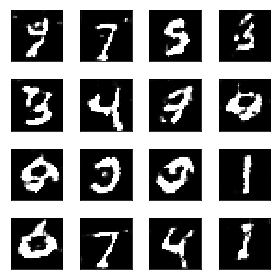

Epoch: 11/100 Discriminator Loss:15.3742 Generator Loss:15.5383
Epoch: 12/100 Discriminator Loss: 8.4576 Generator Loss: 8.9363
Epoch: 13/100 Discriminator Loss: 1.5326 Generator Loss: 1.5018
Epoch: 14/100 Discriminator Loss: 3.0823 Generator Loss: 3.9155
Epoch: 15/100 Discriminator Loss:10.4120 Generator Loss:10.7033
Epoch: 16/100 Discriminator Loss: 8.3763 Generator Loss: 9.8543
Epoch: 17/100 Discriminator Loss:10.3619 Generator Loss:12.6535
Epoch: 18/100 Discriminator Loss: 7.5258 Generator Loss: 7.7581
Epoch: 19/100 Discriminator Loss:13.1014 Generator Loss:13.5424
Epoch: 20/100 Discriminator Loss:10.4903 Generator Loss:13.4529


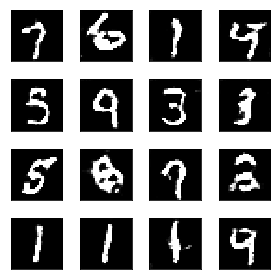

Epoch: 21/100 Discriminator Loss: 6.2211 Generator Loss: 8.8897
Epoch: 22/100 Discriminator Loss: 4.9251 Generator Loss: 5.7722
Epoch: 23/100 Discriminator Loss: 6.1821 Generator Loss: 7.6266
Epoch: 24/100 Discriminator Loss:11.7802 Generator Loss:11.4677
Epoch: 25/100 Discriminator Loss: 4.7250 Generator Loss: 5.8778
Epoch: 26/100 Discriminator Loss: 3.3306 Generator Loss: 3.4018
Epoch: 27/100 Discriminator Loss:10.1091 Generator Loss:10.2178
Epoch: 28/100 Discriminator Loss: 5.1157 Generator Loss: 3.8333
Epoch: 29/100 Discriminator Loss: 3.0988 Generator Loss: 4.9459
Epoch: 30/100 Discriminator Loss: 1.6378 Generator Loss: 0.9683


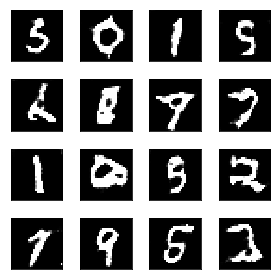

Epoch: 31/100 Discriminator Loss: 9.2314 Generator Loss: 8.1524
Epoch: 32/100 Discriminator Loss: 4.6506 Generator Loss: 4.1856
Epoch: 33/100 Discriminator Loss: 7.9240 Generator Loss: 5.7950
Epoch: 34/100 Discriminator Loss: 1.9039 Generator Loss: 0.5074
Epoch: 35/100 Discriminator Loss: 1.8052 Generator Loss: 3.3429
Epoch: 36/100 Discriminator Loss: 3.9170 Generator Loss: 2.5763
Epoch: 37/100 Discriminator Loss: 2.3131 Generator Loss: 0.3071
Epoch: 38/100 Discriminator Loss: 2.3659 Generator Loss: 3.6115
Epoch: 39/100 Discriminator Loss: 2.0614 Generator Loss: 1.6564
Epoch: 40/100 Discriminator Loss: 1.2488 Generator Loss: 2.8501


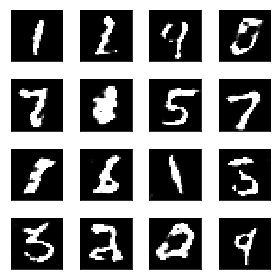

Epoch: 41/100 Discriminator Loss: 2.5889 Generator Loss: 3.7589
Epoch: 42/100 Discriminator Loss: 2.9167 Generator Loss: 1.9997
Epoch: 43/100 Discriminator Loss: 2.9245 Generator Loss: 0.6202
Epoch: 44/100 Discriminator Loss: 2.1128 Generator Loss: 3.3368
Epoch: 45/100 Discriminator Loss: 3.2492 Generator Loss: 4.2225
Epoch: 46/100 Discriminator Loss: 4.1296 Generator Loss: 4.9640
Epoch: 47/100 Discriminator Loss: 2.6042 Generator Loss: 1.6539
Epoch: 48/100 Discriminator Loss: 3.4714 Generator Loss: 0.5374
Epoch: 49/100 Discriminator Loss: 3.5974 Generator Loss: 1.8663
Epoch: 50/100 Discriminator Loss: 5.7665 Generator Loss: 0.1094


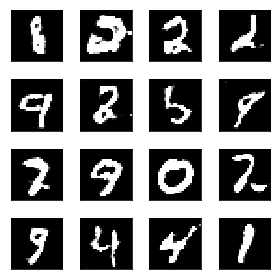

Epoch: 51/100 Discriminator Loss: 5.9112 Generator Loss: 6.1877
Epoch: 52/100 Discriminator Loss: 2.2623 Generator Loss: 2.4794
Epoch: 53/100 Discriminator Loss: 4.1287 Generator Loss: 3.4798
Epoch: 54/100 Discriminator Loss: 2.3484 Generator Loss: 2.0800
Epoch: 55/100 Discriminator Loss: 4.1020 Generator Loss: 2.9285
Epoch: 56/100 Discriminator Loss: 2.5131 Generator Loss: 1.4053
Epoch: 57/100 Discriminator Loss: 2.1460 Generator Loss: 1.1784
Epoch: 58/100 Discriminator Loss: 3.0528 Generator Loss: 3.0915
Epoch: 59/100 Discriminator Loss: 8.5453 Generator Loss: 8.3788
Epoch: 60/100 Discriminator Loss: 4.2532 Generator Loss: 6.0319


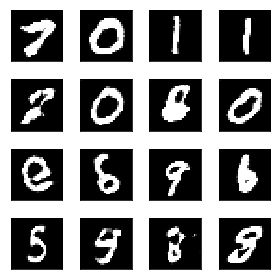

Epoch: 61/100 Discriminator Loss: 4.1354 Generator Loss: 5.5596
Epoch: 62/100 Discriminator Loss: 3.5450 Generator Loss: 3.1150
Epoch: 63/100 Discriminator Loss: 1.9904 Generator Loss: 1.2140
Epoch: 64/100 Discriminator Loss: 7.3968 Generator Loss: 5.3008
Epoch: 65/100 Discriminator Loss: 4.7005 Generator Loss: 4.8975
Epoch: 66/100 Discriminator Loss: 1.9021 Generator Loss: 1.0614
Epoch: 67/100 Discriminator Loss:13.0177 Generator Loss:13.5536
Epoch: 68/100 Discriminator Loss: 2.9813 Generator Loss: 3.8875
Epoch: 69/100 Discriminator Loss: 4.8375 Generator Loss: 5.2585
Epoch: 70/100 Discriminator Loss: 4.2126 Generator Loss: 5.8771


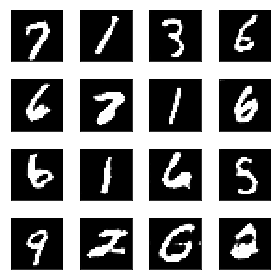

Epoch: 71/100 Discriminator Loss: 4.4632 Generator Loss: 3.2027
Epoch: 72/100 Discriminator Loss: 3.4408 Generator Loss: 1.3738
Epoch: 73/100 Discriminator Loss: 2.4444 Generator Loss: 2.9299
Epoch: 74/100 Discriminator Loss: 9.2413 Generator Loss:10.0638
Epoch: 75/100 Discriminator Loss: 2.9294 Generator Loss: 1.9379
Epoch: 76/100 Discriminator Loss: 5.5667 Generator Loss: 6.1086
Epoch: 77/100 Discriminator Loss: 8.9118 Generator Loss:10.7614
Epoch: 78/100 Discriminator Loss: 5.6332 Generator Loss: 0.8032
Epoch: 79/100 Discriminator Loss: 3.5212 Generator Loss: 5.1413
Epoch: 80/100 Discriminator Loss: 1.9001 Generator Loss: 1.2737


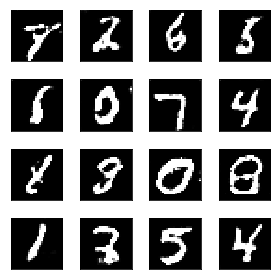

Epoch: 81/100 Discriminator Loss: 2.0527 Generator Loss: 2.5421
Epoch: 82/100 Discriminator Loss: 5.3896 Generator Loss: 6.8680
Epoch: 83/100 Discriminator Loss: 3.0165 Generator Loss: 4.9584
Epoch: 84/100 Discriminator Loss: 3.0527 Generator Loss: 4.0444
Epoch: 85/100 Discriminator Loss: 5.6624 Generator Loss: 8.2014
Epoch: 86/100 Discriminator Loss: 3.9720 Generator Loss: 5.3189
Epoch: 87/100 Discriminator Loss: 6.6438 Generator Loss: 7.9294
Epoch: 88/100 Discriminator Loss:14.6339 Generator Loss:15.3926
Epoch: 89/100 Discriminator Loss: 1.8504 Generator Loss: 2.9884
Epoch: 90/100 Discriminator Loss: 2.7456 Generator Loss: 4.3178


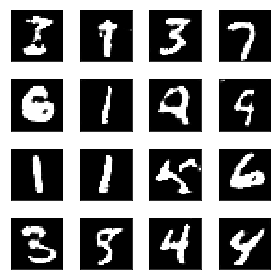

Epoch: 91/100 Discriminator Loss: 3.9397 Generator Loss: 4.9509
Epoch: 92/100 Discriminator Loss: 6.0520 Generator Loss: 9.0871
Epoch: 93/100 Discriminator Loss: 2.4605 Generator Loss: 2.0742
Epoch: 94/100 Discriminator Loss: 3.3597 Generator Loss: 2.1704
Epoch: 95/100 Discriminator Loss: 9.2578 Generator Loss: 9.3821
Epoch: 96/100 Discriminator Loss: 4.1707 Generator Loss: 6.0841
Epoch: 97/100 Discriminator Loss: 7.2785 Generator Loss: 7.5207
Epoch: 98/100 Discriminator Loss: 2.7776 Generator Loss: 0.9368
Epoch: 99/100 Discriminator Loss: 2.7956 Generator Loss: 5.4050
Epoch:100/100 Discriminator Loss: 9.0582 Generator Loss: 9.4374


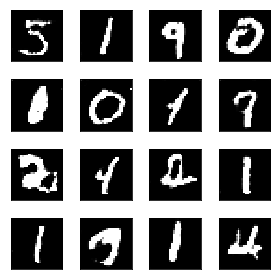

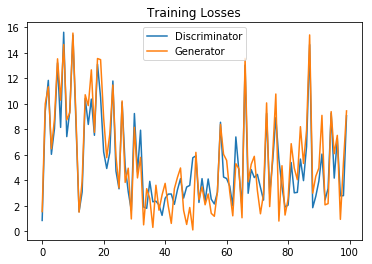

In [15]:
train(g_learning_rate=0.0001, g_beta_1=0.9, d_learning_rate=0.001, d_beta_1=0.9, leaky_alpha=0.2)